In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
import datetime as dt
import matplotlib.pyplot as plt

import requests

# Stock source from yahoo finance

In [2]:
ticker = 'aapl'
# Last 3 years closing prices starting from Jan 2, 2018.
 
now = dt.datetime.now()
startyear = 2018
startmonth = 1 
startday = 2
start = dt.datetime(startyear, startmonth, startday)
df = pdr.get_data_yahoo(ticker, start, now)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-02-23,166.149994,159.750000,165.539993,160.070007,90009200.0,160.070007
2022-02-24,162.850006,152.000000,152.580002,162.740005,141147500.0,162.740005
2022-02-25,165.119995,160.869995,163.839996,164.850006,91974200.0,164.850006
2022-02-28,165.419998,162.429993,163.059998,165.119995,94869100.0,165.119995
2022-03-01,166.600006,161.970001,164.699997,163.199997,83361500.0,163.199997


# Cypto source from HOUBI

In [3]:

base = 'https://api.huobi.pro'
url = '/market/history/kline?period=5min&size=2000&symbol=ethbtc'
final_url = base + url
reqs = requests.get(final_url)

df = pd.DataFrame(reqs.json()['data'])
df.rename(columns={'high':'High','low':'Low','open':'Open','close':'Close','vol':'Volume'},inplace=True)
df['Adj Close']= df['Close']
df = df[['High','Low','Open','Close','Volume','Adj Close']]

df

,High,Low,Open,Close,Volume,Adj Close
0,0.067901,0.067828,0.067849,0.067844,0.198090,0.067844
1,0.067934,0.067848,0.067866,0.067848,1.166208,0.067848
2,0.067921,0.067824,0.067904,0.067860,0.240818,0.067860
3,0.067987,0.067840,0.067840,0.067894,1.751694,0.067894
4,0.067837,0.067714,0.067789,0.067837,0.694015,0.067837
...,...,...,...,...,...,...
1995,0.070187,0.069864,0.070187,0.069940,3.390483,0.069940
1996,0.070238,0.070188,0.070233,0.070195,0.236635,0.070195
1997,0.070261,0.070190,0.070200,0.070219,0.308488,0.070219
1998,0.070233,0.070122,0.070122,0.070168,0.859625,0.070168


In [4]:
## 14_Day RSI
df['Up Move'] = np.nan
df['Down Move'] = np.nan
df['Average Up'] = np.nan
df['Average Down'] = np.nan
# Relative Strength
df['RS'] = np.nan
# Relative Strength Index
df['RSI'] = np.nan

    

# Relative Strength Index (RSI):
## When the RSI surpasses the horizontal 30 reference level, it is a bullish sign and when it slides below the horizontal 70 reference level, it is a bearish sign.

In [5]:
## Calculate Up Move & Down Move
for x in range(1, len(df)):
    df['Up Move'][x] = 0
    df['Down Move'][x] = 0
    
    if df['Adj Close'][x] > df['Adj Close'][x-1]:
        df['Up Move'][x] = df['Adj Close'][x] - df['Adj Close'][x-1]
        
    if df['Adj Close'][x] < df['Adj Close'][x-1]:
        df['Down Move'][x] = abs(df['Adj Close'][x] - df['Adj Close'][x-1])  
        


In [6]:
## Calculate initial Average Up & Down, RS and RSI
df['Average Up'][14] = df['Up Move'][1:15].mean()
df['Average Down'][14] = df['Down Move'][1:15].mean()
df['RS'][14] = df['Average Up'][14] / df['Average Down'][14]
df['RSI'][14] = 100 - (100/(1+df['RS'][14]))


In [7]:
## Calculate rest of Average Up, Average Down, RS, RSI
for x in range(15, len(df)):
    df['Average Up'][x] = (df['Average Up'][x-1]*13+df['Up Move'][x])/14
    df['Average Down'][x] = (df['Average Down'][x-1]*13+df['Down Move'][x])/14
    df['RS'][x] = df['Average Up'][x] / df['Average Down'][x]
    df['RSI'][x] = 100 - (100/(1+df['RS'][x]))

## - You can ‘print(df)’ to see the DataFrame, it should look like a long table with 6 new columns.
# Plot the RSI and ‘Close Prices’ :

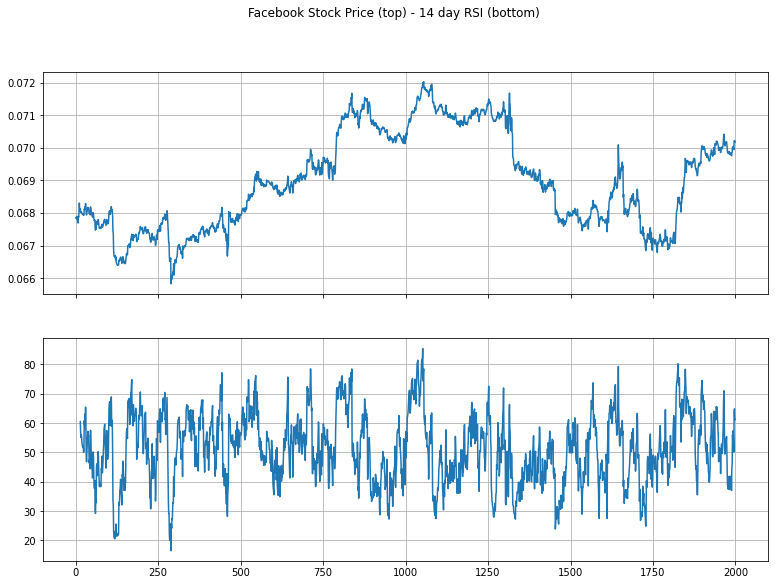

In [8]:
## Chart the stock price and RSI
#plt.style.use('_classic_test')
fig, axs = plt.subplots(2, sharex=True, figsize=(13,9))
fig.suptitle('Facebook Stock Price (top) - 14 day RSI (bottom)')
axs[0].plot(df['Adj Close'])
axs[1].plot(df['RSI'])
axs[0].grid()
axs[1].grid()

# GENERATE BUY & SELL SIGNALS:

In [9]:
## Calculate the buy & sell signals
## Initialize the columns that we need
df['Long Tomorrow'] = np.nan
df['Buy Signal'] = np.nan
df['Sell Signal'] = np.nan
df['Buy RSI'] = np.nan
df['Sell RSI'] = np.nan
df['Strategy'] = np.nan
## Calculate the buy & sell signals
for x in range(15, len(df)):
    
    # Calculate "Long Tomorrow" column
    if ((df['RSI'][x] <= 40) & (df['RSI'][x-1]>40) ):
        df['Long Tomorrow'][x] = True
    elif ((df['Long Tomorrow'][x-1] == True) & (df['RSI'][x] <= 70)):
        df['Long Tomorrow'][x] = True
    else:
        df['Long Tomorrow'][x] = False
        
    # Calculate "Buy Signal" column
    if ((df['Long Tomorrow'][x] == True) & (df['Long Tomorrow'][x-1] == False)):
        df['Buy Signal'][x] = df['Adj Close'][x]
        df['Buy RSI'][x] = df['RSI'][x]
        
    # Calculate "Sell Signal" column
    if ((df['Long Tomorrow'][x] == False) & (df['Long Tomorrow'][x-1] == True)):
        df['Sell Signal'][x] = df['Adj Close'][x]
        df['Sell RSI'][x] = df['RSI'][x]
        
## Calculate strategy performance
df['Strategy'][15] = df['Adj Close'][15]
for x in range(16, len(df)):
    if df['Long Tomorrow'][x-1] == True:
        df['Strategy'][x] = df['Strategy'][x-1]* (df['Adj Close'][x] / df['Adj Close'][x-1])
    else:
        df['Strategy'][x] = df['Strategy'][x-1]

<ipython-input-9-5bd053afbd08>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Buy Signal'][x] = df['Adj Close'][x]
<ipython-input-9-5bd053afbd08>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Buy RSI'][x] = df['RSI'][x]
<ipython-input-9-5bd053afbd08>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sell Signal'][x] = df['Adj Close'][x]
<ipython-input-9-5bd053afbd08>:28: SettingWithCopyWarning: 
A value is trying to 

# Exit / Entry:

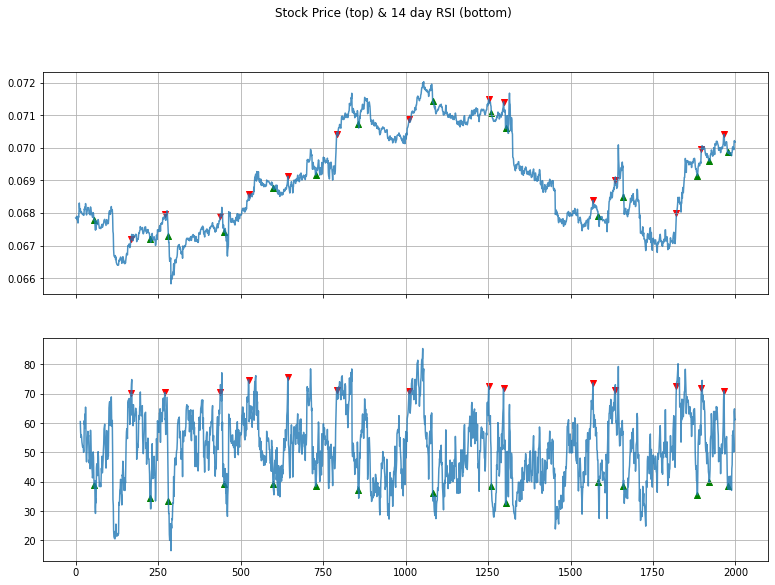

In [10]:
## Chart the buy/sell signals:
#plt.style.use('_classic_test')
fig, axs = plt.subplots(2, sharex=True, figsize=(13,9))
fig.suptitle('Stock Price (top) & 14 day RSI (bottom)')
## Chart the stock close price & buy/sell signals:
axs[0].scatter(df.index, df['Buy Signal'],  color = 'green',  marker = '^', alpha = 1)
axs[0].scatter(df.index, df['Sell Signal'],  color = 'red',  marker = 'v', alpha = 1)
axs[0].plot(df['Adj Close'], alpha = 0.8)
axs[0].grid()
## Chart RSI & buy/sell signals:
axs[1].scatter(df.index, df['Buy RSI'],  color = 'green', marker = '^', alpha = 1)
axs[1].scatter(df.index, df['Sell RSI'],  color = 'red', marker = 'v', alpha = 1)
axs[1].plot(df['RSI'], alpha = 0.8)
axs[1].grid()

# Moving Average Convergence Divergence (MACD):

In [11]:
## Calculate the MACD and Signal Line indicators
## Calculate the Short Term Exponential Moving Average
ShortEMA = df.Close.ewm(span=12, adjust=False).mean() 
## Calculate the Long Term Exponential Moving Average
LongEMA = df.Close.ewm(span=26, adjust=False).mean() 
## Calculate the Moving Average Convergence/Divergence (MACD)
MACD = ShortEMA - LongEMA
## Calcualte the signal line
signal = MACD.ewm(span=9, adjust=False).mean()

## Plot MACD & Signal Line:

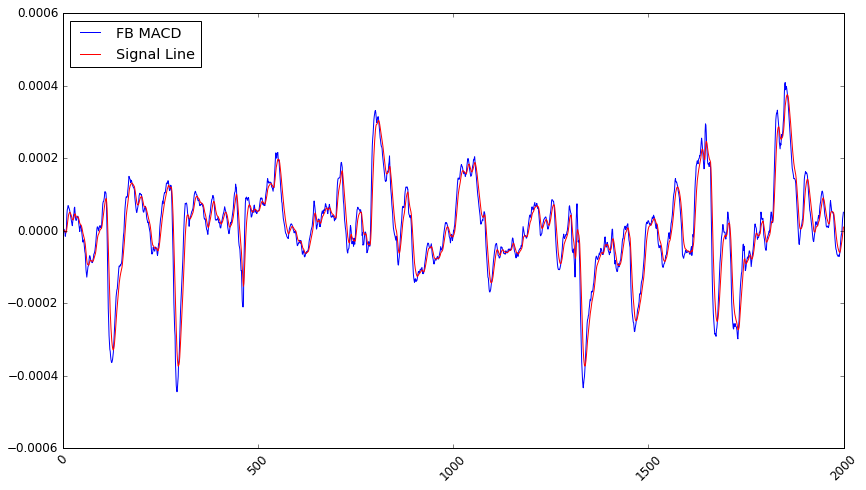

In [12]:
## Plot the Chart
plt.figure(figsize=(14,8))
plt.style.use('classic')
plt.plot(df.index, MACD, label='FB MACD', color = 'blue')
plt.plot(df.index, signal, label='Signal Line', color='red')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

# Trading Facebook 3-Year Metrics:

In [13]:
## Performance statistics
## Number of trades
trade_count = df['Buy Signal'].count()
## Average Profit per/trade:
average_profit = ((df['Strategy'].iloc[-1] / df['Strategy'].iloc[15])**(1/trade_count))-1
## Number of days per/trade
total_days = df['Long Tomorrow'].count()
average_days = int(total_days / trade_count)
print('Strategy yielded ', trade_count, ' trades')
print('Average trade lasted ', average_days, ' days per trade')
print('Our average profit per trade was ', average_profit*100, '%')

Strategy yielded  15  trades
Average trade lasted  132  days per trade
Our average profit per trade was  0.4308515613883568 %


In [14]:
df.head(20)


,High,Low,Open,Close,Volume,Adj Close,Up Move,Down Move,Average Up,Average Down,RS,RSI,Long Tomorrow,Buy Signal,Sell Signal,Buy RSI,Sell RSI,Strategy
0,0.067901,0.067828,0.067849,0.067844,0.198090,0.067844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.067934,0.067848,0.067866,0.067848,1.166208,0.067848,0.000004,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.067921,0.067824,0.067904,0.067860,0.240818,0.067860,0.000012,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.067987,0.067840,0.067840,0.067894,1.751694,0.067894,0.000034,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.067837,0.067714,0.067789,0.067837,0.694015,0.067837,0.000000,0.000057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.067864,0.067777,0.067840,0.067778,0.352853,0.067778,0.000000,0.000059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.067877,0.067703,0.067703,0.067829,4.321268,0.067829,0.000051,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.067894,0.067446,0.067894,0.067690,9.164984,0.067690,0.000000,0.000139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.067931,0.067809,0.067864,0.067905,0.835324,0.067905,0.000215,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.068032,0.067834,0.068032,0.067863,4.400471,0.067863,0.000000,0.000042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df['Strategy'][15]

0.068053

In [16]:
df['Strategy'].iloc[15]

0.068053